# Item based filtering

we take 2 movies ‘A’ and ‘B’ and check their ratings by all users who have rated both the movies and based on the similarity of these ratings, we find similar movies. So if most common users have rated ‘A’ and ‘B’ both similarly and it is highly probable that ‘A’ and ‘B’ are similar, therefore if someone has watched and liked ‘A’ they should be recommended ‘B’ and vice versa.

Advantages over User-based Collaborative Filtering
Unlike people’s taste, movies don’t change.
There are usually a lot fewer items than people, therefore easier to maintain and compute the matrices.
Shilling attacks are much harder because items cannot be faked.

In [1]:
import pandas as pd
import numpy as np
import difflib
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import statistics 

In [2]:
movies = pd.read_csv("./movies.csv")
ratings = pd.read_csv("./ratings.csv")

In [3]:
# movies1 = pd.read_csv("./movies.csv")
# ratings1 = pd.read_csv("archive/rating.csv")

In [4]:
# ratings2 = ratings1.iloc[:3000000,:]
# movies2 = movies1.iloc[:3000000,:]
# # print(ratings.shape)
# ratings2.shape

Ratings dataset has 
* userId - unique for each user
* movieId - using this feature ,we take the title of the movie from movies dataset
* rating - Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies

In [5]:
ratings2 = ratings.reset_index()
movies2 = movies.reset_index()
movies2.head()

,index,movieId,title,genres
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2,Jumanji (1995),Adventure|Children|Fantasy
2,2,3,Grumpier Old Men (1995),Comedy|Romance
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,5,Father of the Bride Part II (1995),Comedy


Movie dataset has 
* movieId - once the recommendation is done, we get list of all similar movieId and get the title for each movie from this dataset. 
* genres -  which is not required for this filtering approach

In [6]:
final_dataset = ratings2.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


We will reduce the noise by adding some filters and qualify the movies for the final dataset.
* To qualify a movie, minimum 80 users should have voted a movie.
* To qualify a user, minimum 100 movies should have voted by the user.

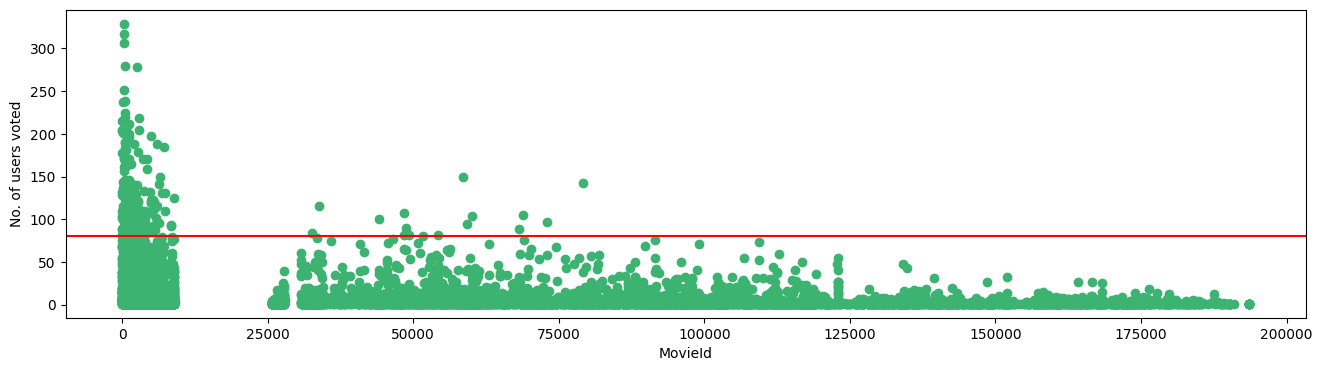

In [8]:
no_user_voted = ratings2.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings2.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=80,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [9]:
# final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 80].index,:]
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]
# print(movies2.shape)
# movies2 = movies2.loc[no_user_voted[no_user_voted > 80].index,:]
# print(movies2.shape)

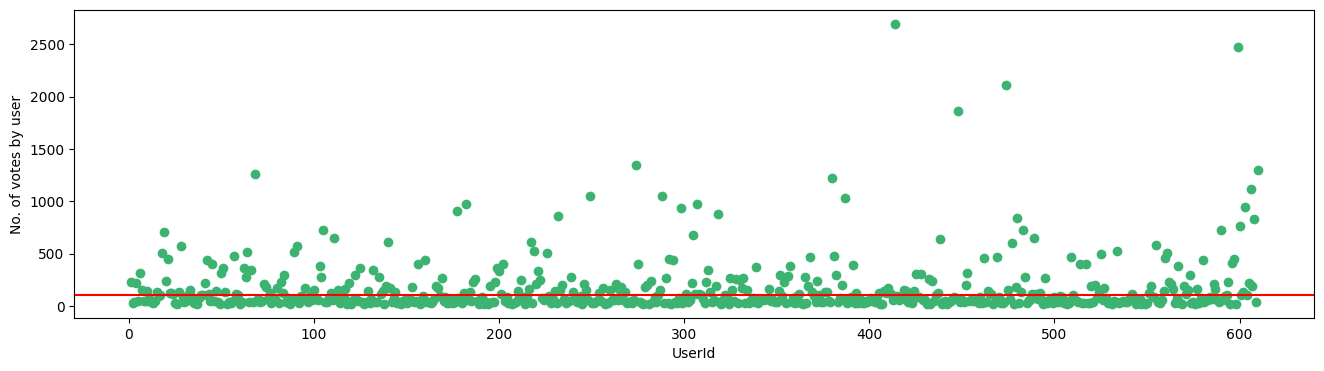

In [10]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=100,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [11]:
# final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 100].index]
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our final_dataset has dimensions of **4375 * 7678** where most of the values are sparse.
To reduce the sparsity we use csr_matric scipy lib. I'll give an example how it works

In [12]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
# sparsity = 1.0 - (np.count_nonzero(sample))
csr_sample = csr_matrix(sample)
print(sample)
print(csr_sample)

[[0 0 3 0 0]
 [4 0 0 0 2]
 [0 0 0 0 1]]
  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [13]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)
# print(csr_data)

We are using cosine distance metric which is very fast and preferable than pearson coefficient. We did not use euclidean distance as it will not work when the values are equidistant.

In [15]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [16]:
def get_movie_recommendation(movie_name):
    n_movies_to_recommend = 10
    list_of_all_titles = movies2['title'].tolist()
    listdiff = difflib.get_close_matches(movie_name, list_of_all_titles,5)
    listcontain = movies2[movies2['title'].str.contains(movie_name,case = False)]
    lis = listcontain["title"].tolist()
    lis.extend(listdiff)
    actual_list = list(set(lis))
    movie_list = []
    for i in actual_list:
        movie_idx = int(movies2[movies2["title"] == i]['movieId'])
        if(final_dataset['movieId'] == movie_idx).any():
            movie_list.append(i)
    for index, value in enumerate(movie_list):
        print(index+1, value)
    if len(movie_list):
        whichmovie = int(input("Which Movie Name Did you mean, Enter the index"))
        if whichmovie > len(movie_list):
            print("sorry wrong index,Please Enter the correct index")
            whichmovie = int(input())
        movie_idx = int(movies2[movies2["title"] == movie_list[whichmovie-1]]['movieId'])
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_recommend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        var = []

        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies2[movies2['movieId'] == movie_idx].index[0]
            var.append(val[1])
            recommend_frame.append({'Title':movies2.iloc[idx]['title'],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_recommend+1))
        res = statistics.variance(var)
        print("The variance of list is : " + str(res))
        return df
    
    else:
        return "No movies found. Please check your input"

In [17]:
get_movie_recommendation('King long')

1 King Kong (2005)
2 King Kong (1976)
3 King Kong (1933)
The variance of list is : 0.00035020070538123915


,Title,Distance
1,X-Men: The Last Stand (2006),0.439958
2,Superman Returns (2006),0.439429
3,Pirates of the Caribbean: Dead Man's Chest (2006),0.436565
4,Wedding Crashers (2005),0.436525
5,Sin City (2005),0.427561
6,War of the Worlds (2005),0.426499
7,"Incredible Hulk, The (2008)",0.422709
8,Star Wars: Episode III - Revenge of the Sith (...,0.408177
9,300 (2007),0.397839
10,Hellboy (2004),0.386277


In [ ]:
get_movie_recommendation('pulp')

1 Pulp Fiction (1994)
sorry wrong index,Please Enter the correct index
The variance of list is : 0.000690076745556597


,Title,Distance
1,Terminator 2: Judgment Day (1991),0.281050
2,"Matrix, The (1999)",0.278063
3,American Beauty (1999),0.275735
4,Reservoir Dogs (1992),0.269770
5,Fargo (1996),0.257769
6,Seven (a.k.a. Se7en) (1995),0.245685
7,Forrest Gump (1994),0.238773
8,"Usual Suspects, The (1995)",0.231888
9,"Shawshank Redemption, The (1994)",0.228397
10,"Silence of the Lambs, The (1991)",0.200882


In [ ]:
# import difflib
movie_name = input(' Enter your favourite movie name : ')
list_of_all_titles = movies['title'].tolist()
find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
print(find_close_match)

[]


In [ ]:
# get_movie_recommendation('Iron Man')
list_of_all_titles = movies2['title'].tolist()
movie_list = difflib.get_close_matches("Iron man", list_of_all_titles,5)
movie_list2 = movies2[movies2['title'].str.contains("Iron man",case = False)]
lis = movie_list2["title"].tolist()
lis.extend(movie_list)
set(lis)
print(lis)

['Iron Man (2008)', 'Iron Man 2 (2010)', 'Invincible Iron Man, The (2007)', 'Iron Man 3 (2013)', 'Iron Man & Hulk: Heroes United (2013)', 'Iron Man (1931)', 'Iron Man (2008)', 'Iron Man (1931)']
